## Acoustic Signal Processing for Bioacoustics
### 04 - Single Channel Noise Reduction

In this notebook, we will look into some basic noise reduction in the STFT domain using a Wiener filter.

Written by: Randall Ali (contact r.ali@surrey.ac.uk for questions/errors/suggestions!)

Firstly let us import several of the packages we will need. If these packages are not available on your machine, you will have to install them first. 

In [31]:
import numpy as np 
import scipy as sp
from scipy import signal
import sounddevice as sd
import soundfile as sf
from matplotlib import pyplot as plt
from  matplotlib import patches
from matplotlib.ticker import FormatStrFormatter
from ipywidgets import * # interactive plots
import IPython
from IPython.display import Audio, Image
%matplotlib ipympl


### Designing a noise reduction filter

#### The workflow

Fig. 1 depicts the workflow of a typical noise reduction process that takes place in the short time Fourier transform (STFT) domain. Our recorded discrete-time noisy signal, $\mathrm{y}[n]$ is firstly converted into the STFT domain, denoted by $\mathrm{y}(k,l)$, where $k$ is the frequency bin, and $l$ is the time frame. A scalar gain (between 0 and 1), $\mathrm{G}(k,l)$ (our noise reduction filter) is then applied to $\mathrm{y}(k,l)$ for each time-frequency bin or "tile" (recall the depiction from notebook 03 on time-freq analysis), i.e., a simple multiplication $\mathrm{G}(k,l)\mathrm{y}(k,l)$ is done, where the idea is that if there is only noise in that time-frequency bin, $\mathrm{G}(k,l)$ will be a smaller value to "reduce" the noise, otherwise  $\mathrm{G}(k,l)$ is set to a higher value (closer to 1) in order to "preserve" the signal of interest. Once this process is complete, we now have an "enhanced" signal in the STFT domain, which can then be converted back into the discrete-time domain via an inverse STFT. It should be noted here that since $\mathrm{G}(k,l)$ is a scalar, only the magnitude of the STFT is changed. It is assumed that the phase of the noisy signal is the same as the enhanced signal, and so this is the phase used for doing the inverse STFT. This is an assumption that is challenged in the noise reduction literature, but for simplicity we stick with it to understand the basic noise reduction concept in this notebook. 

The question you should be asking yourself at this point is - how do I know what values should be assigned to $\mathrm{G}(k,l)$? That is essentially the noise reduction problem - how to find $\mathrm{G}(k,l)$? 

<br>
<br>

<div>
<center> <img src="img/NR_SP_workflow.png" width="650"/> <center/>
    <p style="text-align:center">Fig. 1 - Noise Reduction Signal Processing Workflow </p>
</div>

<br>
<br>


#### A signal model 

One of the important steps of any digital signal processing (DSP) algorithm development is coming up with a signal model, i.e., what is our assumption of what the noisy signal represents? This is the starting point for many DSP algorithms and the validity of this assumption is often what dictates how well an algorithm may work in practice. Such an approach is to be contrasted with more modern machine learning (ML) approaches, where signal models are not necessarily assumed but rather "learned" from data. In my opinion, whether or not one approach is better than the other depends on several factors - how much data is available, how much computing resources one has, how much prior knowledge one has about the process, etc. Hence, I tend to view DSP and ML as distinct approaches and an engineering decision needs to be made as to what is suitable for the particular application at hand.

At any rate, let us define our signal model. We assume that the noisy STFT signal, $\mathrm{y}(k,l)$ consists of two components: (i) the signal of interest, $\mathrm{s}(k,l)$, and the corrupting noise, $\mathrm{n}(k,l)$:

\begin{equation}
\mathrm{y}(k,l) = \mathrm{s}(k,l) + \mathrm{n}(k,l)
\end{equation}

We also make two more assumptions (i) the signal and noise components are uncorrelated and (ii) each time-frequency bin can be treated independently.

#### An optimal filter

From this signal model, we can now come up with various cost functions in an attempt to find an expression for $\mathrm{G}(k,l)$. We call this process optimal filtering - defining some cost function from our signal model, and then solving that to find an "optimal" filter, i.e., optimal in the sense that it minimizes the cost function. 

One popular optimal filter is called the Minimum Mean-Square Estimator (MMSE) or the Wiener filter, which minimizes the mean-squared error between the signal of interest and the filtered noisy signal:

\begin{equation}
\mathrm{G_{WF}}(k,l) = \underset{\mathrm{G}(k,l)}{\text{argmin}} \hspace{0.2cm} \mathbb{E} \{|\mathrm{s}(k,l) - \mathrm{G}(k,l)\hspace{0.05cm}\mathrm{y}(k,l)|^{2}\}
\end{equation}

where $\mathbb{E}\{.\}$ is the expectation operator (one can think of it as averaging). In words, what this equation is saying is to find some $\mathrm{G}(k,l)$ that minimizes the expected (averaged) mean-squared error between the signal of interest and the filtered noisy signal. Another way to understand this is to think of when $\mathrm{G}(k,l)\hspace{0.05cm}\mathrm{y}(k,l) = \mathrm{s}(k,l)$, i.e., we want to find $\mathrm{G}(k,l)$ such that when we multiply it by the noisy signal, we get our signal of interest.

To find the optimal filter, we need to solve this equation. Basically we substitute our signal model, and find $\mathrm{G}(k,l)$ for when the derivate is zero.  I will put the derivation for it in an appendix of this notebook, and just concentrate on the result here. The optimal filter, which we denote as $\mathrm{G_{WF}}(k,l)$ is given by:

\begin{equation}
\mathrm{G_{WF}}(k,l) = \frac{\sigma^{2}_{\mathrm{s}}(k,l)}{\sigma^{2}_{\mathrm{s}}(k,l) + \sigma^{2}_{\mathrm{n}}(k,l)}
\end{equation}
where $\sigma^{2}_{\mathrm{s}}(k,l) = \mathbb{E} \{\mathrm{s}(k,l)\mathrm{s}^{*}(k,l) \}$ is the power spectral density (PSD) of the signal of interest ($^{*}$ is the complex conjugate), and $\sigma^{2}_{\mathrm{n}}(k,l) = \mathbb{E} \{\mathrm{n}(k,l)\mathrm{n}^{*}(k,l) \}$ is the PSD of the noise. Therefore, the enhanced signal estimate in each time-frequency bin will be given by:

\begin{equation}
\hat{\mathrm{s}}(k,l) = \frac{\sigma^{2}_{\mathrm{s}}(k,l)}{\sigma^{2}_{\mathrm{s}}(k,l) + \sigma^{2}_{\mathrm{n}}(k,l)} \mathrm{y}(k,l)
\end{equation}

#### Signal and noise PSD estimates

So we know what the optimal filter, $\mathrm{G_{WF}}(k,l)$ is, but there is yet another problem! How do we find the signal and noise PSDs? This is in fact the core of the single-channel noise reduction process and there has been decades of research into this problem. See the references for a text which provides an overview of a range of methods for estimating signal and noise PSDs. Most of these have been developed for speech enhancement, so certain methods may/may not be appropriate for the bioacoustics domain, and hence obtaining such estimates is still an open research problem. 

To get an idea of how the entire process works though, we are going to use some very simple (not necessarily the best) estimates of the signal and noise PSDs. 

##### Noise PSDs
Let's first deal with the noise PSDs, we can estimate them from the data as follows:

\begin{equation}
{\hat{\sigma}^{2}_{\mathrm{n}}(k,l)} = \begin{cases}
\alpha_{n}{\hat{\sigma}^{2}_{\mathrm{n}}(k,l-1)} + (1-\alpha_{n}){{|\mathrm{y}(k,l)|}^{2}} & \text{noise frames}\\
\hat{\sigma}^{2}_{\mathrm{n}}(k,l-1)             & \text{signal frames}
\end{cases}
\end{equation}

where $\alpha_n \in [0, 1]$ is a "forgetting factor", where smaller values correspond to faster updates, and larger values average over a longer period, i.e. slower updates (suitable if the noise is fairly stationary). What's important to note here is that we need some sort of detection to tell us when the signal of interest is active. So whenever the signal is active, we let the noise PSD estimate be the value in the previous frame, otherwise, it's updated with exponential smoothing with $\alpha_n$ a free parameter that needs to be chosen. 

##### Speech PSDs

The speech PSDs can then be updated as follows:

\begin{equation}
{\hat{\sigma}^{2}_{\mathrm{s}}(k,l)} = \text{max}\left(
\alpha_{s} \hspace{0.02cm} {{|\mathrm{\hat{s}}(k,l-1)|}^{2}} + (1-\alpha_{s})\left({{|\mathrm{y}(k,l)|^{2} - {\hat{\sigma}^{2}_{\mathrm{n}}(k,l)}}}\right), \hspace{0.05cm} \xi_{\text{min}} \hspace{0.01cm}{\hat{\sigma}^{2}_{\mathrm{n}}(k,l)} \right)
\end{equation}

where the $\text{max}$ function returns the maximum value from its two arguments, $\alpha_s \in [0, 1]$ is another "forgetting factor" (also where smaller values correspond to faster updates, and larger values to slower updates), and $\xi_{\text{min}}$ is a scaling for setting minimum value of the signal PSD (this is to avoid the values in the time-frequency bins to be exactly zero as this is known to cause artificats in the noise-reduced signal). What we see in the first argmuent of the $ \text{max}$ function is that the signal PSD is exponentially smoothed with its previous value and one that is computed as $\left({{|\mathrm{y}(k,l)|^{2} - {\hat{\sigma}^{2}_{\mathrm{n}}(k,l)}}}\right)$. This in fact follows from the assumption that the signal and noise were uncorrelated (i.e., from that assumption, we could state that $ \mathbb{E}\{|\mathrm{y}(k,l)|^{2}\} = {\sigma}^{2}_{\mathrm{s}}(k,l) + {\sigma}^{2}_{\mathrm{n}}(k,l)$).

Okay, that is al the background we need. Let's see how this actually works in practice!


In [32]:
# We need to firstly define a function for signal activity detection
# There are many more sophisticated algorithms for this, but we do the most basic here by defining the signal as
# active, if the energy of the noisy signal exceeds some pre-defined threshold
# What we'll see is that the detection is critical for a good noise reduction.

def compute_SAD(chunk_x,thrs): # Signal Activity Detection
    # Compute short-term signal energy
    energy = np.mean(np.abs(chunk_x)**2)
    # Assign SAD value
    if energy > thrs:
        SADout = 1
    else:
        SADout = 0
    return SADout



Text(0.5, 1.0, 'Recorded signal y[m]')

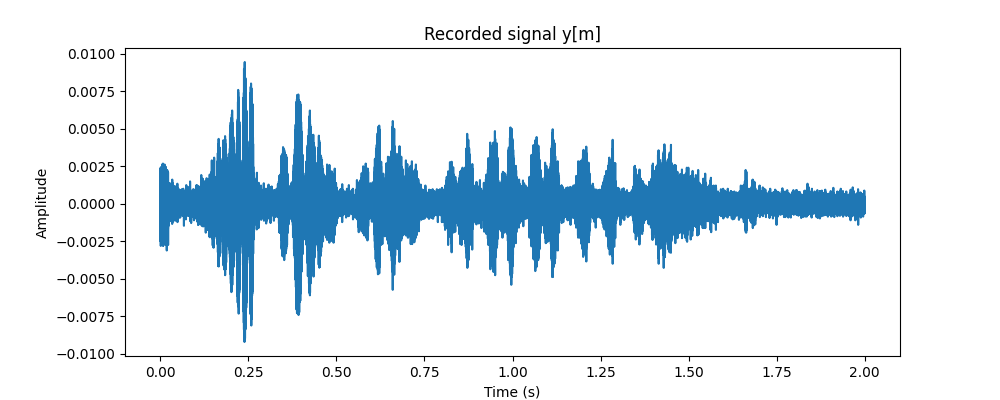

In [33]:
# Let's import our noisy signal

[y_raw,fs] = sf.read('./audio/CHE_01_autocorr_edit.wav') # Read in your audio file
y = y_raw[1*fs:3*fs] # Extract a section
y = y - np.mean(y)   # Removing the mean of the signal
del y_raw

N = len(y)
tt = np.arange(0,N,1)*(1/fs) # time vector

# Listen
IPython.display.display(Audio(y.T, rate=fs))


# Time domain plot
fig, axes = plt.subplots(figsize=(10, 4)) 
axes.plot(tt,y, label = 'Desired')
axes.set_xlabel('Time (s)')
axes.set_ylabel('Amplitude')
axes.set_title('Recorded signal y[m]')



(257, 126)


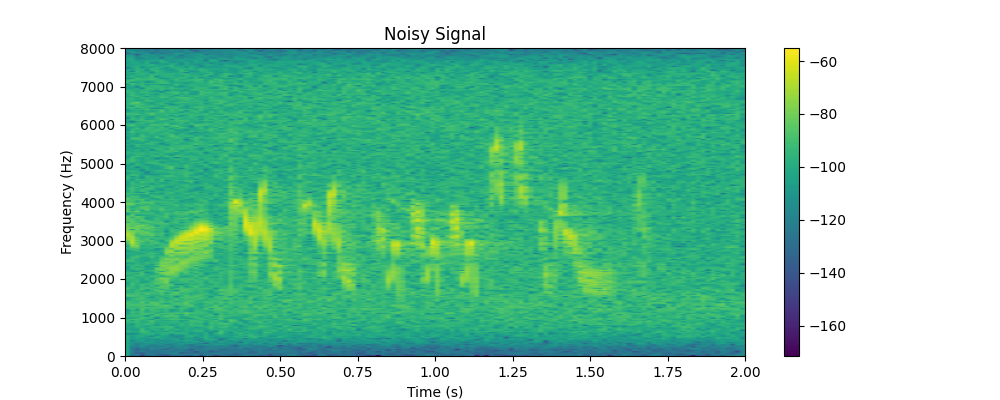

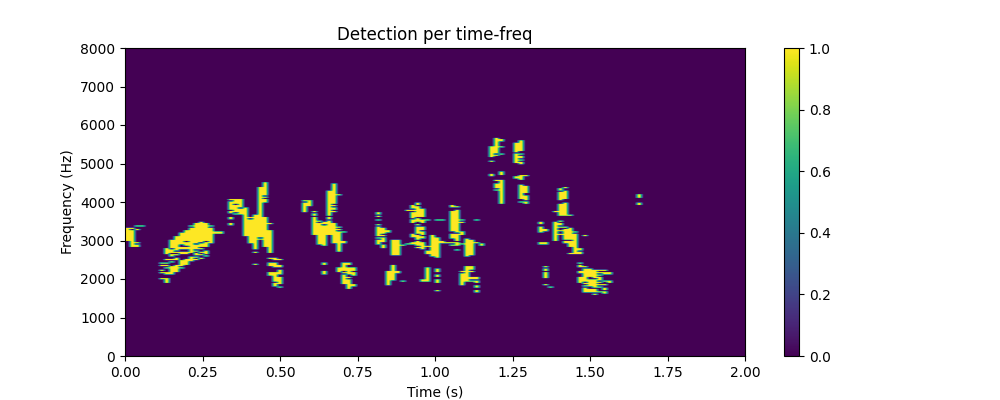

In [35]:
# Transforming into the STFT domain

# parameters:
nfft = 512         # number of samples for each frame of the STFT
noverlap = nfft/2  # Spectrogram overlap (make it 50 %)
win = np.sqrt(np.hanning(nfft)) 

# Compute STFT
f, t, Y = signal.stft(y,fs=fs,window=win,nperseg=len(win),noverlap=noverlap,return_onesided=True)
Y_dB = 10*np.log10(np.abs(Y)**2) # magnitude in dB

vmin = np.min(Y_dB)
vmax = np.max(Y_dB)

# These are just some extra parameters for the imshow function, which allows you to plot a spectrogram
# The extent parameter is defining the corners of the image
extent = t[0], t[-1], f[0], f[-1]  # this defines the 4 corners of the "image"
fig, axes = plt.subplots(figsize=(10, 4)) 
sp = axes.imshow(Y_dB, origin='lower',aspect='auto',extent=extent, vmin=vmin, vmax=vmax)
axes.set_xlabel('Time (s)')
axes.set_ylabel('Frequency (Hz)')
axes.set_title('Noisy Signal')
cb = plt.colorbar(sp,ax=[axes],location='right')


# Signal Activity Detection - we can plot this to see which STFT regions the signal is being detection
SAD_out = np.zeros(Y.shape)
thr = 1e-8    # SAD threshold - adjust to see the difference
print(SAD_out.shape)

for l in range(len(t)):    
    # Loop over frequency bins
    for k in range(len(f)):
        SAD_out[k,l]= compute_SAD(Y[k,l],thr)
        
extent = t[0], t[-1], f[0], f[-1]  # this defines the 4 corners of the "image"
fig, axes = plt.subplots(figsize=(10, 4)) 
sp = axes.imshow(SAD_out, origin='lower',aspect='auto',extent=extent)
axes.set_xlabel('Time (s)')
axes.set_ylabel('Frequency (Hz)')
axes.set_title('Detection per time-freq')
cb = plt.colorbar(sp,ax=[axes],location='right')        


In [36]:
# Noise Reduction function - this computes the speech and noise PSDs, G(k,l), and the noise-reduced signal

def single_channel_NR(Y, alpha_n, alpha_s, Xi_min):

    # INPUTS:
    # Y - STFT of the noisy input signal (matrix)
    # alpha_n - noise PSD
    # alpha_s - signal PSD
    # Xi_min  - a noise floor threshold

    # OUTPUTS:
    # S_sc_stft - Noise-reduced STFT signal representation (matrix)
    # s_hat - Noise-reduced discrete-time domain signal
    
    sig_s = np.zeros(Y.shape);
    sig_n = np.zeros(Y.shape);
    G_sc_stft = np.zeros(Y.shape);  # Single Channel gain
    S_sc_stft = np.zeros_like(Y);  # Speech estimate
    
    for l in np.arange(1,len(t),1):
    
            # Loop over frequency bins
            for k in range(len(f)):
                    
                if SAD_out[k,l]:
                    sig_n[k,l] = sig_n[k,l-1];                
                else:
                    sig_n[k,l] = alpha_n*sig_n[k,l-1] + (1-alpha_n)*(np.abs(Y[k,l])**2) # update noise in noise-only frames
                    
                
                # Speech PSD estimation
                sig_s[k,l] = np.maximum( (alpha_s*np.abs(S_sc_stft[k,l-1])**2 + (1-alpha_s)*(np.abs(Y[k,l])**2 - sig_n[k,l])) , Xi_min*sig_n[k,l]); 
                # Wiener Filter
                G_sc_stft[k,l] = (sig_s[k,l])/(sig_s[k,l] + sig_n[k,l]);
                
                # Speech Estimate
                S_sc_stft[k,l] = G_sc_stft[k,l]*Y[k,l];
                
    
    # # Go back to time domain
    _, s_hat = signal.istft(S_sc_stft,fs=fs,window=win,nperseg=len(win),noverlap=noverlap)
    s_hat = s_hat[0:len(y)]

    return S_sc_stft, s_hat


Move the slider to see how the noise reduction performance changes as a function of the forgetting factors noise floor threshold:


interactive(children=(FloatSlider(value=0.1, description='alpha_n', max=0.99, min=0.01, step=0.01), FloatSlide…

Noisy recorded signal:


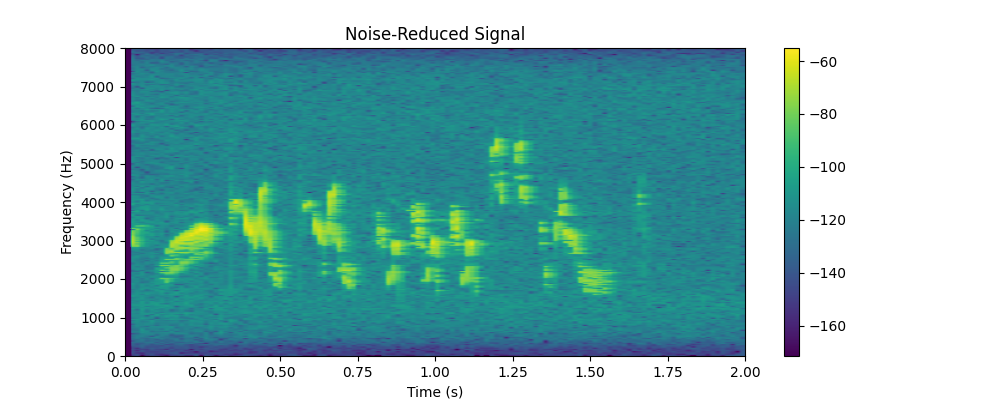

In [37]:
# Single Channel Noise Reduction
# interactive plot

# Plot Enhanced and Time Domain Signal

extent = t[0], t[-1], f[0], f[-1]  # this defines the 4 corners of the "image"
fig, axes = plt.subplots(figsize=(10, 4)) 
specg = axes.imshow(10*np.log10(np.abs(Y+1e-16)**2), origin='lower',aspect='auto',extent=extent, vmin=vmin, vmax=vmax)
axes.set_xlabel('Time (s)')
axes.set_ylabel('Frequency (Hz)')
axes.set_title('Noise-Reduced Signal')
cb = plt.colorbar(specg,ax=[axes],location='right')


alpha_n = 0.1;  alpha_s = 0.9999; # speech and noise forgetting factors 
Xi_min = 1e-1;  

# The interactive plot:
def update(alpha_n = 0.1, alpha_s = 0.5, Xi_min = 1e-1):

    S_sc_stft, s_hat = single_channel_NR(Y, alpha_n, alpha_s, Xi_min)
    specg.set_data(10*np.log10(np.abs(S_sc_stft+1e-16)**2))

    print("Enhanced (Noise-Reduced) Signal:")
    IPython.display.display(Audio(s_hat.T, rate=fs,normalize=True))

print('Move the slider to see how the noise reduction performance changes as a function of the forgetting factors noise floor threshold:')
interact(update, alpha_n = (0.01,0.99,0.01), alpha_s = (0.01,0.99,0.01), Xi_min = (1e-5,1,1e-5));

# print("Data shape: ", y.shape)
print("Noisy recorded signal:")
IPython.display.display(Audio(y.T, rate=fs,normalize=True))



# # Uncomment below to see the time-domain plot
# fig, axes = plt.subplots(figsize=(8, 3)) 
# axes.plot(tt,y, label = 'Noisy')
# axes.plot(tt,s_hat, label = 'Enhanced')
# axes.set_xlabel('Time (s)')
# axes.set_ylabel('Amplitude')
# # axes.set_title('Enhanced signal y[m]')
# plt.legend()



### Appendix - Derivation for finding the optimal filter

I'm dropping the $(k,l)$ dependence in the following so as to not clutter the notation too much.

Let's begin by recalling the minimum mean-square estimator cost function, which we denote as $J$, and expand it out. Recall that these quantities are all complex numbers as we are in the STFT domain (but G is a scalar!) and that $^{*}$ represents the complex conjugate. $\Re(.)$ also denotes the real part of a complex number.

\begin{align}
J &=  \mathbb{E} \{|\mathrm{s} - \mathrm{G}\hspace{0.05cm}\mathrm{y}|^{2}\} \nonumber \\
 &= \mathbb{E} \{(\mathrm{s} - \mathrm{G}\hspace{0.05cm}\mathrm{y})  (\mathrm{s^{*}} - \mathrm{G}\hspace{0.05cm}\mathrm{y^{*}})\} \nonumber \\
&= \mathbb{E} \{\mathrm{s}\mathrm{s^{*}}\} - G\mathbb{E} \{\mathrm{s}\mathrm{y^{*}}\} - G\mathbb{E} \{\mathrm{y}\mathrm{s^{*}}\}   + G^{2}\mathbb{E} \{\mathrm{y}\mathrm{y^{*}}\} \nonumber \\
&= \mathbb{E} \{\mathrm{s}\mathrm{s^{*}}\} - 2 G\Re (\mathbb{E} \{\mathrm{s}\mathrm{y^{*}}\})   + G^{2}\mathbb{E} \{\mathrm{y}\mathrm{y^{*}}\} \nonumber 
\end{align}

To find the optimal "G", we need to take the derivative of this cost function with respect to G and set that to zero, i.e., $dJ/dG = 0$:

\begin{align}
\frac{dJ}{dG} &=0 \\
 - 2 \Re (\mathbb{E} \{\mathrm{s}\mathrm{y^{*}}\})   + 2 G\mathbb{E} \{\mathrm{y}\mathrm{y^{*}}\} & = 0\nonumber \\
\end{align}

from which we can proceed to solve for G:

\begin{align}
G &= \frac{\Re (\mathbb{E} \{\mathrm{s}\mathrm{y^{*}}\}) }{\mathbb{E} \{\mathrm{y}\mathrm{y^{*}}\} } \nonumber \\
G &= \frac{\Re (\mathbb{E} \{\mathrm{s}\mathrm{(s^{*}+n^{*})}\}) }{\mathbb{E} \{\mathrm{(s+n)}\mathrm{(s^{*}+n^{*})}\} } \nonumber 
\end{align}

Because we made the assumption that the signal and the noise are uncorrelated, it follows that $ \mathbb{E} \{\mathrm{s}\mathrm{n^{*}}\} =  \mathbb{E} \{\mathrm{n}\mathrm{s^{*}}\}  = 0$, and hence we get:

\begin{align}
G &= \frac{ \mathbb{E} \{\mathrm{s}\mathrm{s^{*}} \} }{\mathbb{E} \{\mathrm{s}\mathrm{s^{*}}\} + \mathbb{E} \{\mathrm{n}\mathrm{n^{*}}\} }  =  \frac{\sigma^{2}_{\mathrm{s}}(k,l)}{\sigma^{2}_{\mathrm{s}}(k,l) + \sigma^{2}_{\mathrm{n}}(k,l)}\nonumber \\
\end{align}


### References

1. Hendriks R.C., Gerkmann T., Jensen J. DFT-Domain Based Noise Reduction for Speech Enhancement. Synthesis Lectures on Speech and Audio Processing. 2013. 1-80 p. Available from: https://link.springer.com/book/10.1007/978-3-031-02564-8
2. Gannot S, Vincent E, Markovich-golan S, Ozerov A. A Consolidated Perspective on Multimicrophone Speech Enhancement and Source Separation. IEEE Trans Audio, Speech Lang Process. 2017;25(4):692–730. https://ieeexplore.ieee.org/document/7805139
3. R.Ali, Multi-microphone Speech Enhancement: An Integration of A Priori and Data-dependent Spatial Information (Ch. 2), Ph.D. thesis, KU Leuven, 2020. https://theses.eurasip.org/theses/881/multi-microphone-speech-enhancement-an/ (I am including my thesis here as Chapter 2, specifically 2.7.2 gives a concise summary of how much of this works and there are many references which I point to.)